In [116]:
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder 
import torchvision.transforms as T
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

In [117]:
DATA_DIR = '../input/indian-sign-language-isl/Indian'
batch_size = 32
image_size = 64
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [118]:
train_ds = ImageFolder(DATA_DIR,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))
train_dl = DataLoader(train_ds,batch_size,num_workers=4,pin_memory=True)

torch.Size([32, 3, 64, 64])


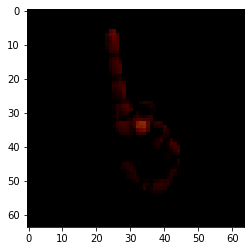

In [119]:
for i,l in train_dl:
    print(i.shape)
    plt.imshow(i[0].permute(1, 2, 0))
    break

In [120]:
def denorm(img_tensors):
    return img_tensors* stats[1][0] + stats[0][0]

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [122]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)
    

In [123]:
train_dl = DeviceDataLoader(train_dl,device)

In [124]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)
    
    
discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [125]:
class Generator(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(Generator, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
generator = Generator()

In [126]:
generator.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [127]:
EPOCH = 20
LR = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))

In [128]:
for epoch in range(EPOCH):
    for i, data in enumerate(train_dl, 0):
        discriminator.zero_grad()
        
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0])).to(device)
        output = discriminator(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
        fake = generator(noise)
        target = Variable(torch.zeros(input.size()[0])).to(device)
        output = discriminator(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        # 2nd Step: Updating the weights of the neural network of the generator
        generator.zero_grad()
        target = Variable(torch.ones(input.size()[0])).to(device)
        output = discriminator(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(train_dl), errD.item(), errG.item()))
            vutils.save_image(real, 'real_samples.png', normalize=True)
            fake = generator(noise)
            vutils.save_image(fake.data, f'fake_samples_epoch_{epoch}_{i}.png', normalize=True)

[0/20][0/1336] Loss_D: 1.6296; Loss_G: 8.1068
[0/20][100/1336] Loss_D: 2.4253; Loss_G: 10.2357
[0/20][200/1336] Loss_D: 2.0803; Loss_G: 0.6053
[0/20][300/1336] Loss_D: 15.0357; Loss_G: 3.7627
[0/20][400/1336] Loss_D: 0.9580; Loss_G: 3.0656
[0/20][500/1336] Loss_D: 0.4149; Loss_G: 5.4116
[0/20][600/1336] Loss_D: 1.1059; Loss_G: 0.9076
[0/20][700/1336] Loss_D: 0.1118; Loss_G: 6.0845
[0/20][800/1336] Loss_D: 2.6145; Loss_G: 1.2622
[0/20][900/1336] Loss_D: 0.2420; Loss_G: 4.4662
[0/20][1000/1336] Loss_D: 0.3277; Loss_G: 3.3940


KeyboardInterrupt: 